# Market Price Estimation — BMW cars' auctions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import levene

from datetime import datetime
import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

## Introduction

The B2B automobile auction dataset gathers around 5k BMW cars sold in 2018. Besides the registration date (the date when the cars where initially sold and put into circulation), the dataset has complete features ranging from car type, to fuel, paint color, model, mileage, eight other equipement features tagged 'feature_1' to 'feature_8' and of course, price.

For starters, this work will aim to assess which are the most determinant features that influence the price of a car at the time of an auction. Our methodology will consist in comparing different regression models such as linear regressions, random forest and gradient boosting. Then, the focus will be put into a broad analysis of inferences using time-series modeling tools primarly. This will settle the ground for a forecast analysis based on a plausible client scenario that will be explained further on.

### 1. Exploratory Data Analysis

To begin with, we will search for straighforward insights such as distributions and other KPI as a way of understanding the shape and the logic of how the data was gathered and parsed;  also as a means of problematizing our subject. 



In [3]:
df_raw = pd.read_csv("auctions.csv")
df = df_raw.copy()

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   maker_key          4843 non-null   object
 1   model_key          4843 non-null   object
 2   mileage            4843 non-null   int64 
 3   engine_power       4843 non-null   int64 
 4   registration_date  4843 non-null   object
 5   fuel               4843 non-null   object
 6   paint_color        4843 non-null   object
 7   car_type           4843 non-null   object
 8   feature_1          4843 non-null   bool  
 9   feature_2          4843 non-null   bool  
 10  feature_3          4843 non-null   bool  
 11  feature_4          4843 non-null   bool  
 12  feature_5          4843 non-null   bool  
 13  feature_6          4843 non-null   bool  
 14  feature_7          4843 non-null   bool  
 15  feature_8          4843 non-null   bool  
 16  price              4843 non-null   int64 


In [5]:
df_raw.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2/1/2012,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,1/1/2018
1,BMW,M4,13929,317,4/1/2016,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2/1/2018
2,BMW,320,183297,120,4/1/2012,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2/1/2018
3,BMW,420,128035,135,7/1/2014,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2/1/2018
4,BMW,425,97097,160,12/1/2014,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,4/1/2018


There are 5 categorical columns, 3 numerical columns (including price), 8 booleans and 2 date format columns.

In [6]:
columns = ['maker_key', 'model_key', 'fuel', 'paint_color', 'car_type']

def description(columns):
    result = []
    for column in columns:
        result.append(f"There are {df[column].nunique()} different {column}s.\n")
    return result

descriptions = description(columns)
for desc in descriptions:
    print(desc)

There are 1 different maker_keys.

There are 75 different model_keys.

There are 4 different fuels.

There are 10 different paint_colors.

There are 8 different car_types.



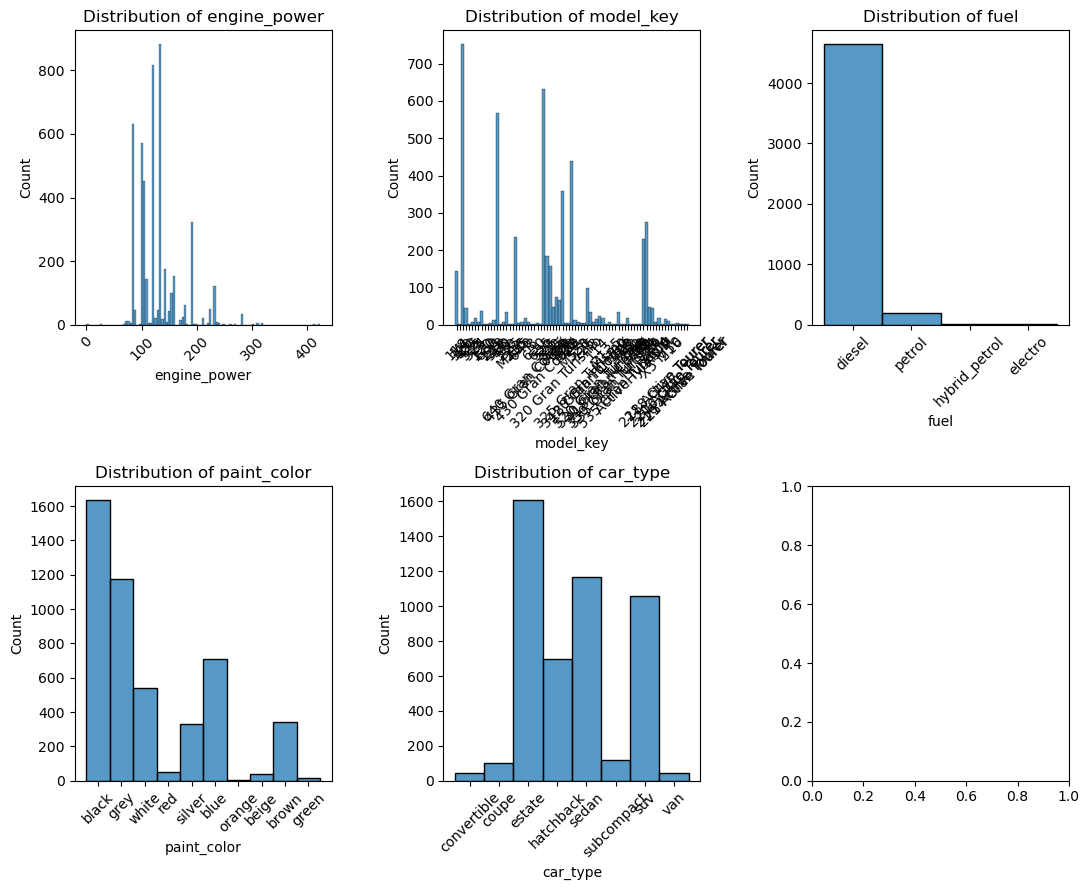

In [7]:
mets = ['engine_power', 'model_key', 'fuel', 'paint_color', 'car_type']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 9))

axes = axes.flatten()

for i, metric in enumerate(mets):
    ax = axes[i]
    sns.histplot(data=df, x=metric, ax=ax)
    ax.set_title(f"Distribution of {metric}")
    ax.tick_params(axis='x', rotation=45)  # Set x-axis tick labels rotation

plt.tight_layout()
plt.show()

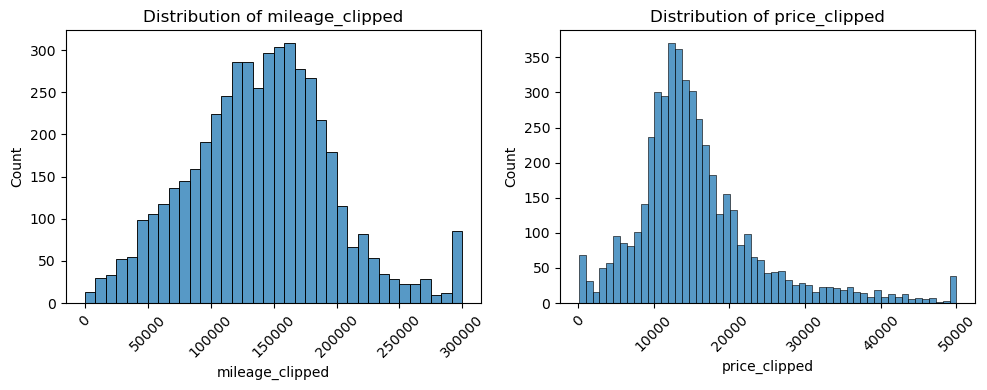

In [8]:
df_1 = df_raw.copy()
df_1["mileage_clipped"]= df_1['mileage'].clip(upper=300000)
df_1["price_clipped"]= df["price"].clip(upper=50000)

mets_1 = ['mileage_clipped', 'price_clipped']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes = axes.flatten()

for i, metric in enumerate(mets_1):
    ax = axes[i]
    sns.histplot(data=df_1, x=metric, ax=ax)
    ax.set_title(f"Distribution of {metric}")
    ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

In [9]:
expensive_cars = df[df['price'] > 50000]
print(f"There are {len(expensive_cars)} expensive cars (more than 50k dollars)")

There are 32 expensive cars (more than 50k dollars)


In [10]:
high_milers = df[df['mileage'] > 300000]
print(f"There are {len(high_milers)} high milers (more than 300k miles)")

There are 76 high milers (more than 300k miles)


In [11]:
print('The most expensive car costs ' + str(df["price"].max()) + ' dollars')
print('The oldest car is from ' + str(df['registration_date'].min()))
print('The most recent car is from ' + str(df['registration_date'].max()))

f"There have been {df['sold_at'].nunique()} different auction dates, all the same week."

The most expensive car costs 178500 dollars
The oldest car is from 1/1/1994
The most recent car is from 9/1/2016


'There have been 9 different auction dates, all the same week.'

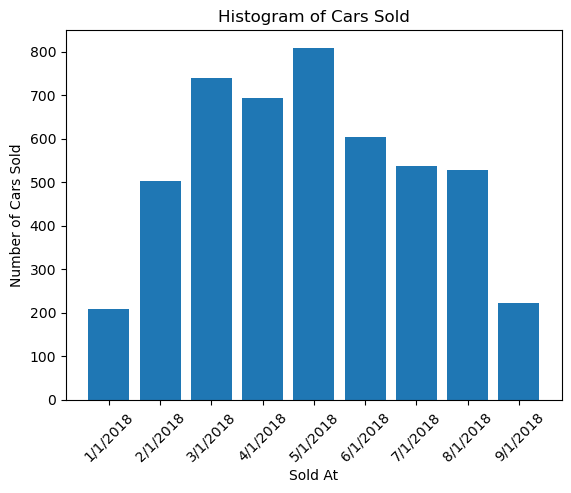

In [12]:
sold_at_counts = df['sold_at'].value_counts().sort_index()

plt.bar(sold_at_counts.index, sold_at_counts.values)
plt.xlabel('Sold At')
plt.ylabel('Number of Cars Sold')
plt.title('Histogram of Cars Sold')
plt.xticks(rotation=45) 
plt.show()

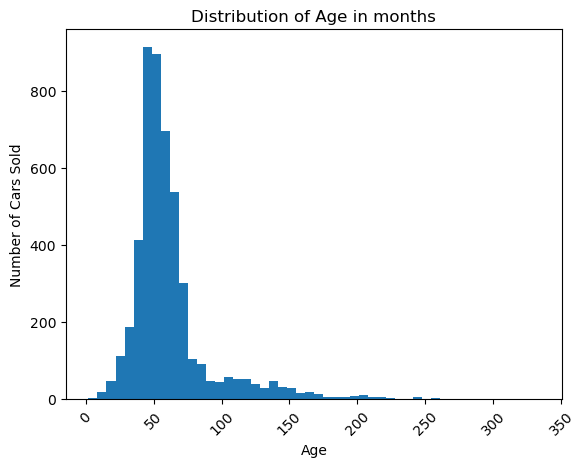

In [13]:
registration_counts = df['registration_date'].value_counts().sort_index()
df["registration_date"] = pd.to_datetime(df["registration_date"])

fixed_date = pd.to_datetime('1/1/2018')
df["age"] = (fixed_date.year - df["registration_date"].dt.year) * 12 + (fixed_date.month - df["registration_date"].dt.month)

age_distribution = df['age'].value_counts().sort_index()
plt.hist(df['age'], bins=50)
plt.xlabel('Age')
plt.ylabel('Number of Cars Sold')
plt.title('Distribution of Age in months')
plt.xticks(rotation=45)
plt.show()

### 2. Price analysis using Machine Learning Models

The relation between pricing and the other features in the dataset is not simple to determine based on our previous analysis.
We will now use Machine Learning algorithms to model the relation between the car's features (features) and their price (target).

Our goal at this stage, is to privilege readability rather than performance, meaning that stock algorithms such as scikit-learn's linear regression, random forest and xgboost, which are among the most popular, should suffice.

#### 2.1. Setup

_2.1.1. Data cleaning_

At the moment of splitting our data into training and testing sets, we need to eliminate categories that have only one item in 'model_key' column. But beforehand we must be sure that the dataset will keep the same relation with reality upon cleaning. 

We will test if the elimination of those items has a statistically significant impact.

In [14]:
df_test = df_raw.copy()
df_test_counts = df_test['model_key'].value_counts()
df_test_trunc = df_test[df_test['model_key'].isin(df_test_counts[df_test_counts > 1].index)]

In [15]:
t_statistic, p_value = ttest_ind(df_test_trunc['price'], df_test['price'], equal_var=False)

print("T-test pour la colonne 'price':")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Différence statistiquement significative dans les moyennes\n")
else:
    print("Pas de différence statistiquement significative dans les moyennes\n")

T-test pour la colonne 'price':
T-statistic: -0.11057626011275971
P-value: 0.9119546680317866
Pas de différence statistiquement significative dans les moyennes



In [16]:
levene_statistic, p_value = levene(df_test_trunc['price'], df_test['price'])

print("Statistiques pour la colonne 'price':")
print(f"Levene stat: {levene_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Différence statistiquement significative dans les écart-types\n")
else:
    print("Pas de différence statistiquement significative dans les écart-types\n")

Statistiques pour la colonne 'price':
Levene stat: 0.019484686430782598
P-value: 0.8889887778099471
Pas de différence statistiquement significative dans les écart-types



We are now shure that we can get rid of single item categories.

In [17]:
df_counts = df['model_key'].value_counts()
selected_indices = df_counts[df_counts > 1].index
df = df[df['model_key'].isin(selected_indices)]

_2.1.1. Preprocessing pipeline_

In [97]:
numerical_feats = ['mileage', 'engine_power', 'age']
categorical_feats = ['model_key', 'fuel', 'paint_color', 'car_type']


In [20]:
scaler = StandardScaler()
dummifier = OneHotEncoder()

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', scaler, numerical_feats),
        ('categorical', dummifier, categorical_feats)
    ],
    remainder='passthrough'
)

_2.1.2. X, y split_

In [22]:
X = df.drop(
    columns=[
        'price', 'sold_at', 'maker_key', 'registration_date'
        ])
        
y = df[["price"]]

_2.1.3. Test/Train split_

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=43)

_2.1.4. Model selection_

In [24]:
models = [
    #LinearRegression(),
    Ridge(),
    Lasso(),
    RandomForestRegressor(n_estimators=100, random_state=43),
    xgb.XGBRegressor()
    
]

#### 2.2 Model implementation

_2.2.1. Actual preprocessing_

In [25]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

_2.2.1. Training pipeline_

In [26]:
for model in models:
    start = time.time()
    model.fit(X_train,y_train)
    end = time.time()
    print(type(model).__name__)
    print("")
    print("Time : {:.4f} sec".format(end-start))
    print("Train Score : {:.3f} , Test Score : {:.3f}".format(model.score(X_train,y_train), model.score(X_test,y_test)))
    print("Root mean square error : {:.0f}".format(mean_squared_error(y_test,model.predict(X_test))**(1/2)))
    print(40*"—")

Ridge

Time : 0.0282 sec
Train Score : 0.794 , Test Score : 0.610
Root mean square error : 6342
————————————————————————————————————————
Lasso

Time : 0.4215 sec
Train Score : 0.795 , Test Score : 0.611
Root mean square error : 6334
————————————————————————————————————————


/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_14575/2521573251.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RandomForestRegressor

Time : 6.8315 sec
Train Score : 0.978 , Test Score : 0.673
Root mean square error : 5807
————————————————————————————————————————
XGBRegressor

Time : 0.2225 sec
Train Score : 0.975 , Test Score : 0.631
Root mean square error : 6168
————————————————————————————————————————


_2.2.2. Fine tuning and crossvalidation using gridsearch_

In [27]:
# Linear Regressions

LR_parameters = {
    "alpha":[0.001, 0.01, 0.1, 1, 3, 6, 10, 50, 100]
}

In [28]:
# RandomForestRegressor

RF_parameters = {
    "n_estimators": [200,300],
    "max_depth": [10, 20],
    "min_samples_split": [5,10],
    "min_samples_leaf": [1,3]
}

In [29]:
# XGBoostRegressor

XGB_parameters = {
    'n_estimators': [200,300],
    'max_depth': [1,2,4],
    'gamma':[0,0.1,0.2]

}

In [30]:
param_grids = [LR_parameters, LR_parameters, RF_parameters, XGB_parameters]

for model, param_grid in zip(models, param_grids):
    start = time.time()

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)

    end = time.time()

    
    print(type(model).__name__)
    print("Time: {:.4f} sec".format(end - start))
    print('')
    print("Best Parameters:", grid_search.best_params_)
    print("Best R2-Score (r2):", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_

    print("Train Score: {:.3f}, Test Score: {:.3f}".format(
        best_model.score(X_train, y_train), best_model.score(X_test, y_test)))
    
    y_pred = best_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("Root Mean Square Error: {:.0f}".format(rmse))
    
    print(40 * "—")

Ridge
Time: 0.3505 sec

Best Parameters: {'alpha': 1}
Best R2-Score (r2): 0.7730184814917996
Train Score: 0.794, Test Score: 0.610
Root Mean Square Error: 6342
————————————————————————————————————————


/usr/local/Caskroom/miniconda/base/envs/cours/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5608783950.13662, tolerance: 21146793.986024845
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/Caskroom/miniconda/base/envs/cours/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 542643955.576355, tolerance: 20223681.13043478
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/Caskroom/miniconda/base/envs/cours/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13006042731.701565, tolerance: 19511895.993788823
  model = cd_fast.sparse_enet_coordinate_

Lasso
Time: 6.0976 sec

Best Parameters: {'alpha': 1}
Best R2-Score (r2): 0.7720233310790895
Train Score: 0.795, Test Score: 0.611
Root Mean Square Error: 6334
————————————————————————————————————————


/usr/local/Caskroom/miniconda/base/envs/cours/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: 

#### 2.4. Feature importance extraction

In [82]:
regressor = RandomForestRegressor(n_estimators=100, random_state=43)
regressor.fit(X_train, y_train)
feature_importances = regressor.feature_importances_

/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_14575/1566463129.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


In [83]:
categorical_column_names = preprocessor.transformers_[1][1].categories_
numerical_column_names = X.loc[:, numerical_feats].columns
column_names = list(X.columns)
boolean_column_names = [col for col in column_names if X[col].dtype == bool]

In [84]:
all_column_names = []
flat_categorical_column_names = np.concatenate(categorical_column_names)
all_column_names = np.append(flat_categorical_column_names, numerical_column_names)
all_column_names = np.append(all_column_names, boolean_column_names)

In [85]:
feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":regressor.feature_importances_
})

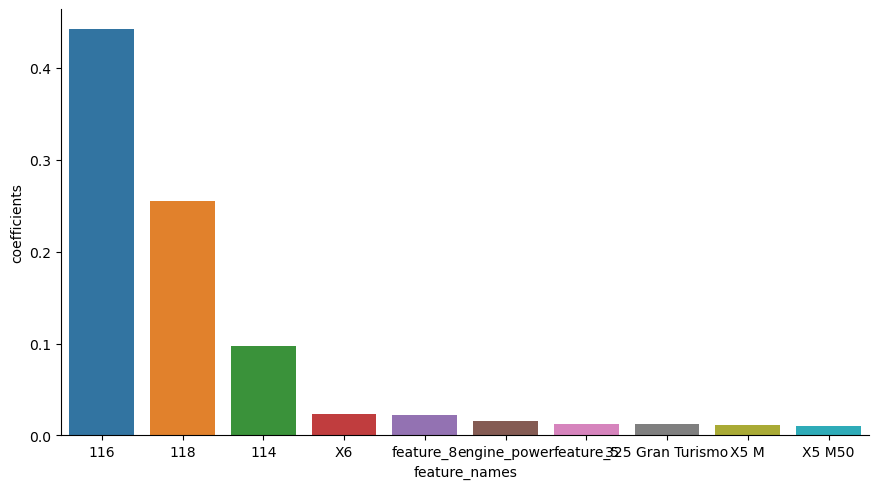

In [86]:
feature_importance["coefficients"] = feature_importance["coefficients"].abs()

sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by="coefficients", ascending=False).head(10), 
            kind="bar",
            aspect=16/9)


In [90]:
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)
feature_importances1 = regressor1.coef_

In [93]:
feature_importances1

array([[-1.99892323e+03,  1.97971325e+03, -2.60685489e+03,
        -6.47858683e+03, -6.41101999e+03, -6.37377752e+03,
        -6.15863118e+03, -8.98449818e+03, -8.40085896e+03,
        -7.61687998e+03, -7.92345513e+02,  5.05313350e+02,
        -5.06269480e+03,  3.88621185e+02, -2.33454240e+03,
        -6.01614762e+03, -4.79988637e+03, -4.25688547e+03,
        -3.03768220e+03, -4.74480021e+03, -3.48252116e+03,
        -6.54678519e+03,  1.49462310e+02, -4.16065445e+03,
        -5.76329771e+03, -2.63567200e+03, -1.22460838e+03,
        -2.74758408e+03, -5.52824597e+02,  5.31435464e+02,
        -8.89672201e+01,  4.74726795e+03,  2.05638502e+03,
         5.98357307e+02,  2.61781084e+02,  2.54843454e+03,
        -1.85742255e+03, -1.93519565e+03, -4.28929323e+01,
         4.14728971e+01, -2.09231253e+03, -1.71842330e+03,
        -1.59013272e+03, -8.75863411e+02, -1.65642221e+03,
        -2.95373619e+03,  7.80426104e+03,  1.13661068e+04,
        -2.03478075e+04,  2.80989529e+03,  1.11144141e+0

In [94]:
feature_importance1 = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":feature_importances1.flatten()
})


In [95]:
feature_importance1

,feature_names,coefficients
0,114,-1998.923233
1,116,1979.713250
2,118,-2606.854886
3,120,-6478.586832
4,123,-6411.019992
...,...,...
91,feature_4,1275.837860
92,feature_5,25.310871
93,feature_6,1205.888409
94,feature_7,1282.975368


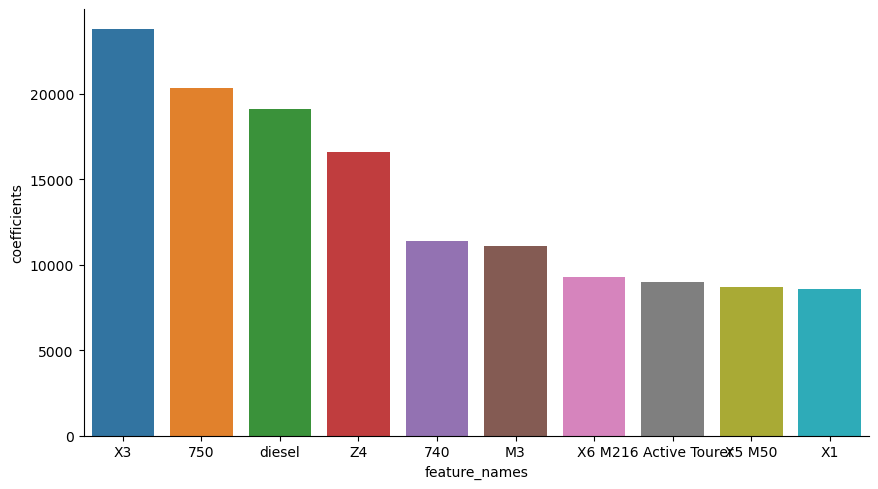

In [96]:
feature_importance1["coefficients"] = feature_importance1["coefficients"].abs()

sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance1.sort_values(by="coefficients", ascending=False).head(10), 
            kind="bar",
            aspect=16/9)